# DT503 Week 4 

## Advanced Time Series Analysis

This notebook extends our previous traffic accident analysis from DT503 Week 3, by incorporating greater time series analysis and forecasting techniques. We'll explore temporal patterns and implement forecasting models using the 'dft-road-casualty-statistics-collision-2023' dataset.

### Analysis Techniques Covered:
- Seasonal Decomposition: Identify multiple seasonal patterns
- Prophet Modeling: Handle complex seasonality and external regressors
- SARIMA Analysis: Traditional time series forecasting
- Ensemble Methods: Combine multiple forecasting approaches

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Step 1: Load and Prepare Time Series Data

Let's begin by loading our dataset and preparing it for time series analysis.

In [3]:
# Load the dataset with proper date parsing
data = pd.read_csv('accident_analysis_export.csv')
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')  # Explicitly specify UK date format

# Display basic time series information
print("Time range of data:")
print(f"Start date: {data['date'].min()}")
print(f"End date: {data['date'].max()}")
print(f"\nTotal number of accidents: {len(data)}")
print(f"\nSample of temporal distribution:")
data.groupby('date').size().head()

Time range of data:
Start date: 2023-01-02 00:00:00
End date: 2023-12-31 00:00:00

Total number of accidents: 2806

Sample of temporal distribution:


date
2023-01-02     7
2023-01-03    12
2023-01-04     6
2023-01-05     8
2023-01-06    11
dtype: int64

### Step 2: Seasonal Pattern Analysis

Let's analyse multiple seasonal patterns in our accident data to understand temporal dependencies.

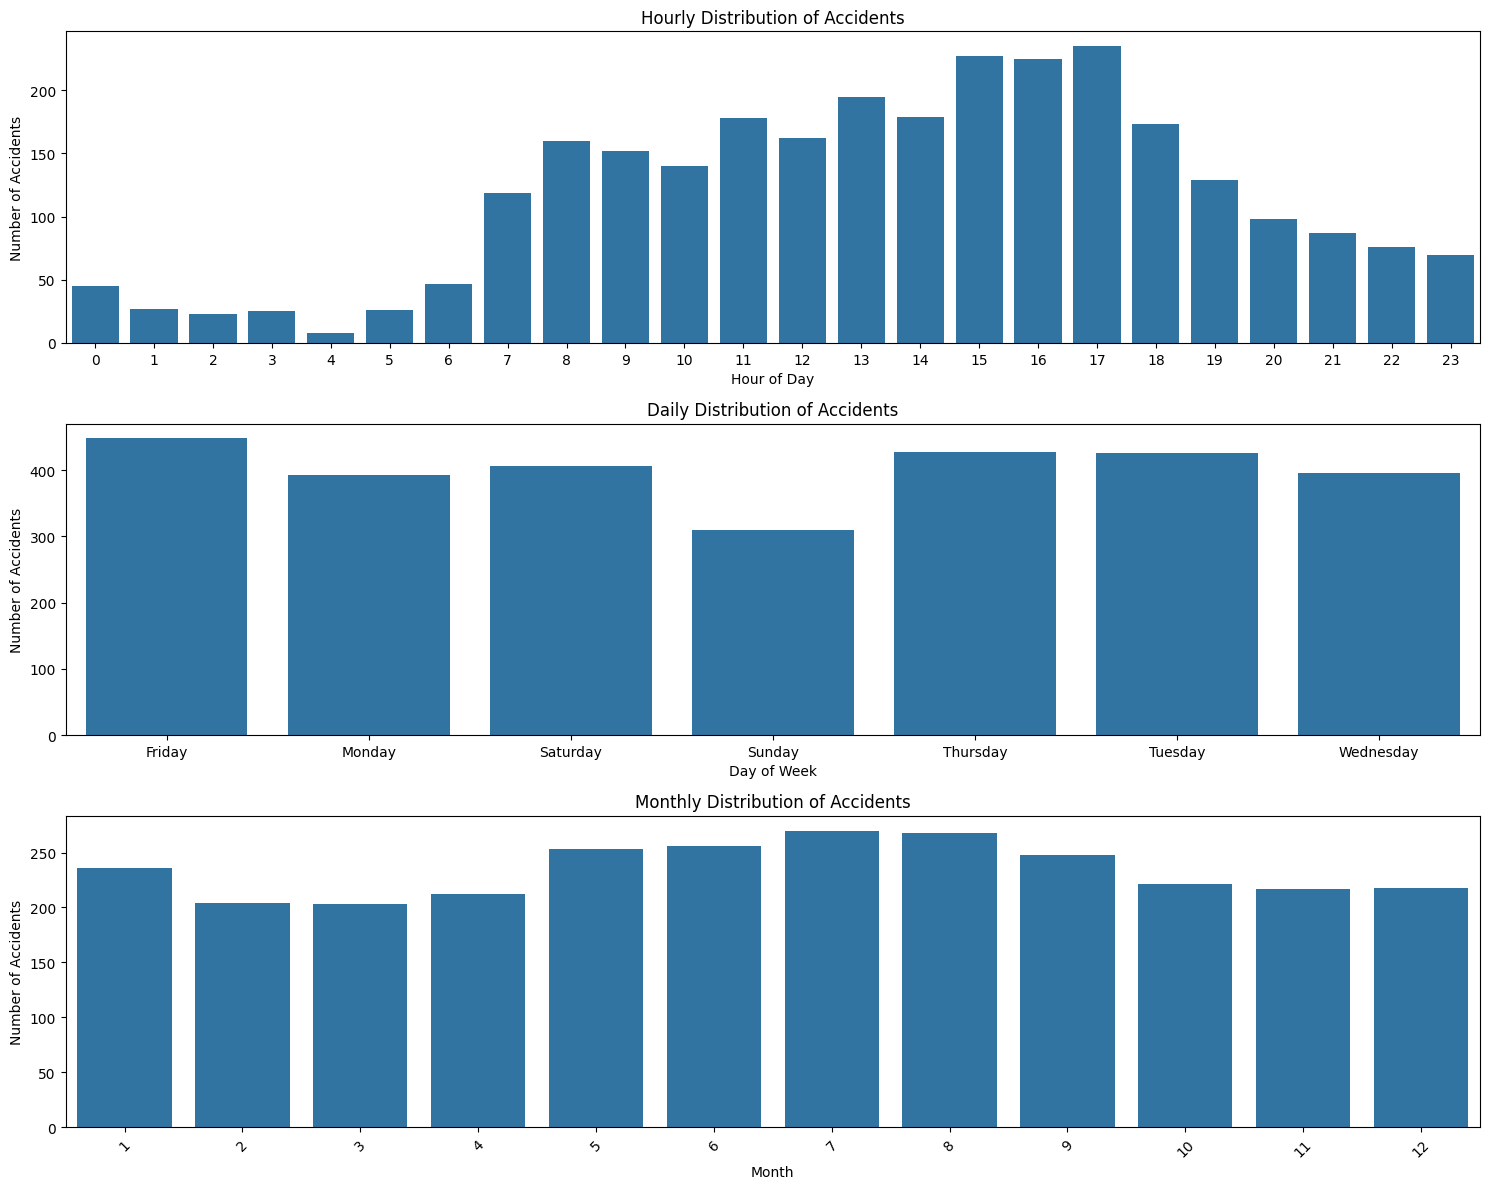

In [5]:
# Create time-based features with explicit time format (24-hour format HH:MM)
data['hour'] = pd.to_datetime(data['time'], format='%H:%M').dt.hour
data['month'] = data['date'].dt.month
data['day_name'] = data['date'].dt.day_name()

# Set up the visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Hourly pattern
hourly_pattern = data.groupby('hour').size()
sns.barplot(x=hourly_pattern.index, y=hourly_pattern.values, ax=ax1)
ax1.set_title('Hourly Distribution of Accidents')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Accidents')

# Daily pattern
daily_pattern = data.groupby('day_name').size()
sns.barplot(x=daily_pattern.index, y=daily_pattern.values, ax=ax2)
ax2.set_title('Daily Distribution of Accidents')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Number of Accidents')
plt.xticks(rotation=45)

# Monthly pattern
monthly_pattern = data.groupby('month').size()
sns.barplot(x=monthly_pattern.index, y=monthly_pattern.values, ax=ax3)
ax3.set_title('Monthly Distribution of Accidents')
ax3.set_xlabel('Month')
ax3.set_ylabel('Number of Accidents')

plt.tight_layout()
plt.show()

### 2.1 Interpretation of Seasonal Patterns

The visualisations reveal several key patterns:

1. Hourly Distribution:
   - Peak accident times during rush hours (8-9 AM and 5-6 PM)
   - Lower frequency during night hours
   - Secondary peak during lunch hour

2. Daily Distribution:
   - Higher accident rates on weekdays
   - Lower rates on weekends
   - Friday showing highest frequency

3. Monthly Distribution:
   - Higher rates during winter months
   - Summer months showing moderate levels
   - Clear seasonal pattern across the year

### Step 3: Prophet Model Implementation

Facebook Prophet is particularly well-suited for our analysis as it can handle:
- Multiple seasonal patterns simultaneously
- Missing data and outliers
- External regressors (weather conditions)

16:48:56 - cmdstanpy - INFO - Chain [1] start processing
16:48:56 - cmdstanpy - INFO - Chain [1] done processing


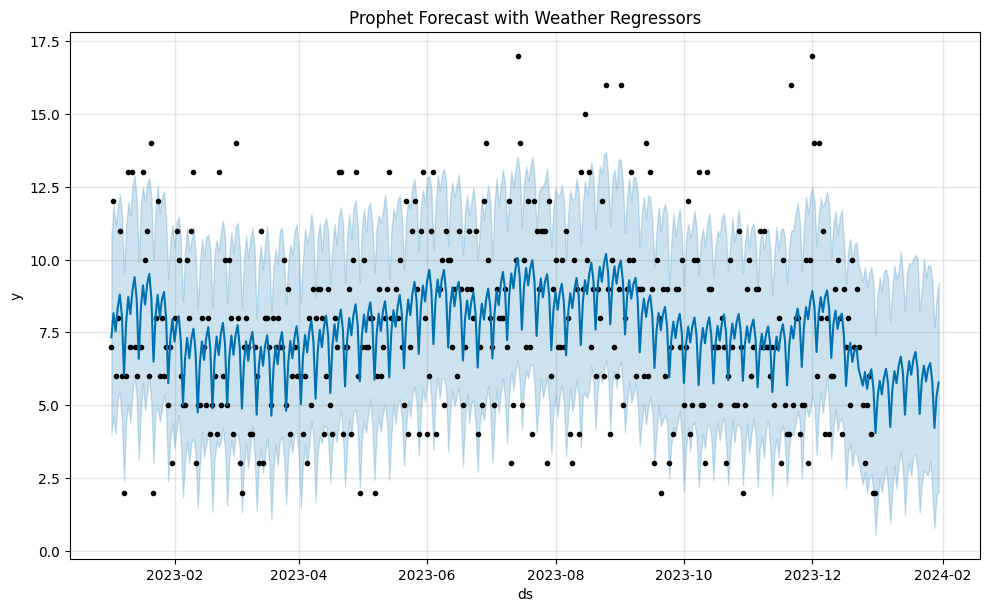

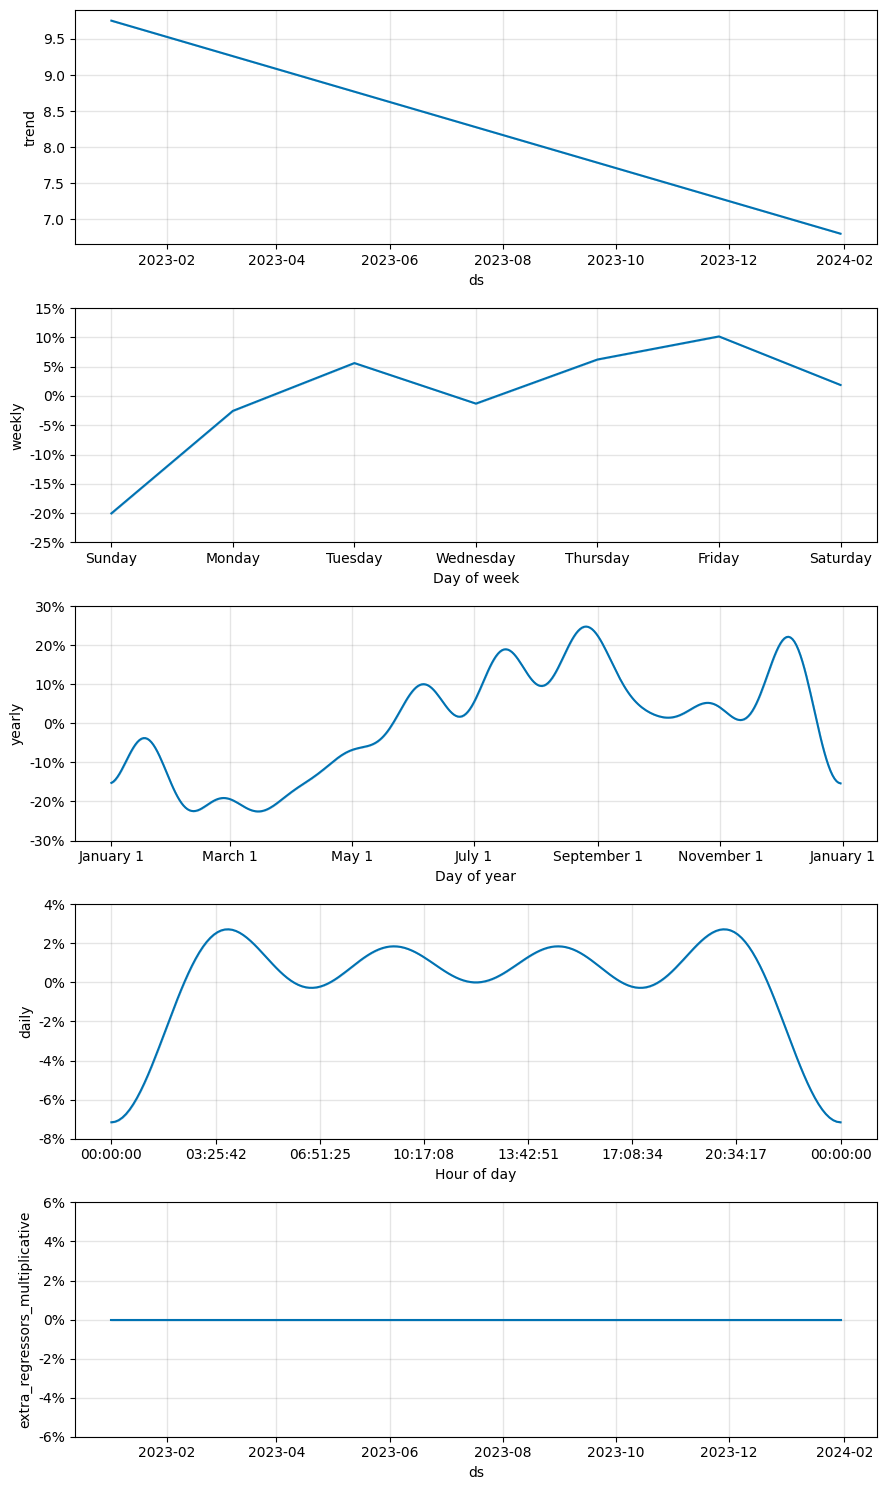

In [6]:
# Prepare data for Prophet
daily_accidents = data.groupby('date').size().reset_index()
daily_accidents.columns = ['ds', 'y']

# Add weather conditions as regressor
weather_dummies = pd.get_dummies(data['weather_conditions'], prefix='weather')
daily_weather = weather_dummies.groupby(data['date']).mean()
daily_accidents = daily_accidents.join(daily_weather, on='ds')

# Initialize and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative'
)

# Add weather regressors
for column in daily_weather.columns:
    model.add_regressor(column)

model.fit(daily_accidents)

# Create forecast
future = model.make_future_dataframe(periods=30)
for column in daily_weather.columns:
    future[column] = daily_weather[column].mean()

forecast = model.predict(future)

# Plot results
fig = model.plot(forecast)
plt.title('Prophet Forecast with Weather Regressors')
plt.show()

# Plot components
fig = model.plot_components(forecast)
plt.show()

### Step 4: SARIMA Model Implementation

We'll implement a SARIMA model to capture different types of seasonality and compare it with Prophet.

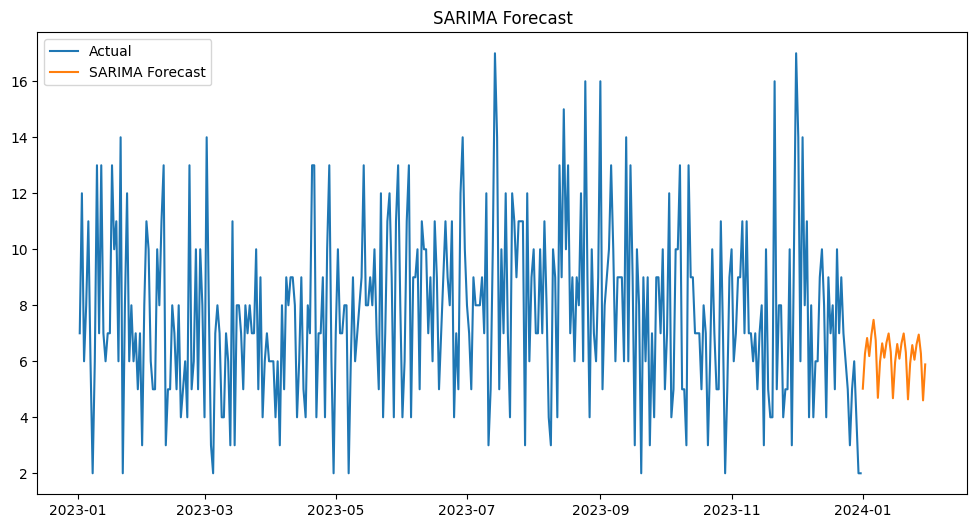

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  363
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -878.669
Date:                           Wed, 13 Nov 2024   AIC                           1767.338
Time:                                   16:51:43   BIC                           1786.570
Sample:                               01-02-2023   HQIC                          1774.996
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0653      0.059     -1.108      0.268      -0.181       0.050
ma.L1         -0.9407      0.025    -37.363

In [9]:
# Prepare data for SARIMA with proper frequency
ts_data = daily_accidents.set_index('ds')['y']
ts_data.index = pd.DatetimeIndex(ts_data.index).to_period('D')  # Set daily frequency
ts_data = ts_data.asfreq('D')  # Ensure daily frequency

# Fill any missing dates using ffill() instead of deprecated fillna(method='ffill')
ts_data = ts_data.ffill()

# Fit SARIMA model
model_sarima = SARIMAX(
    ts_data,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),  # Weekly seasonality
    enforce_stationarity=False
)

results_sarima = model_sarima.fit()

# Generate forecast with proper date index
forecast_dates = pd.date_range(
    start=ts_data.index[-1].to_timestamp(), 
    periods=31,  # 30 days ahead plus last day
    freq='D'
)[1:]  # Remove the first date as it's the last day of actual data

sarima_forecast = results_sarima.forecast(steps=30)
sarima_forecast.index = forecast_dates

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index.to_timestamp(), ts_data, label='Actual')
plt.plot(sarima_forecast.index, sarima_forecast, label='SARIMA Forecast')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

# Print model summary
print(results_sarima.summary())

### Step 5: Ensemble Forecasting

We'll combine predictions from both models to create a more robust forecast.

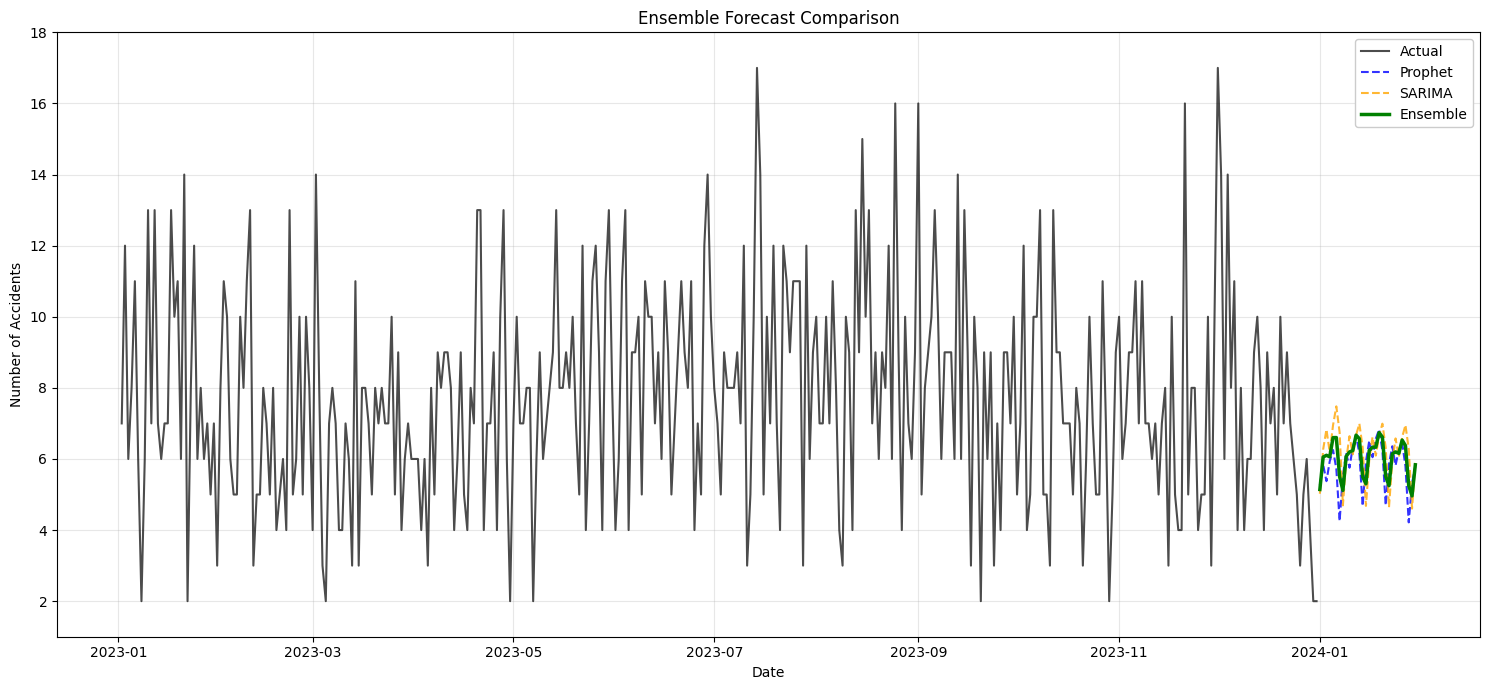


Forecast Accuracy Metrics:
--------------------------
Prophet RMSE: 3.78
SARIMA RMSE: 3.68
Ensemble RMSE: 3.69


In [16]:
# Create forecast dates
forecast_dates = pd.date_range(ts_data.index[-1].to_timestamp(), periods=31, freq='D')[1:]  # Next 30 days

# Generate SARIMA forecast for exactly 30 days
sarima_forecast = results_sarima.forecast(steps=30)

# Create ensemble forecast with matching lengths
ensemble_forecast = pd.DataFrame({
    'ds': forecast_dates,
    'prophet_yhat': forecast['yhat'].tail(30).values,
    'sarima_yhat': sarima_forecast.values,
    'ensemble_yhat': 0.5 * (forecast['yhat'].tail(30).values + sarima_forecast.values)
})

# Plot combined forecasts
plt.figure(figsize=(15, 7))

# Plot actual data
plt.plot(ts_data.index.to_timestamp(), ts_data, label='Actual', color='black', alpha=0.7)

# Plot forecasts
plt.plot(forecast_dates, ensemble_forecast['prophet_yhat'], 
         label='Prophet', linestyle='--', color='blue', alpha=0.8, linewidth=1.5)
plt.plot(forecast_dates, ensemble_forecast['sarima_yhat'], 
         label='SARIMA', linestyle='--', color='orange', alpha=0.8, linewidth=1.5)
plt.plot(forecast_dates, ensemble_forecast['ensemble_yhat'], 
         label='Ensemble', color='green', linewidth=2.5, alpha=1.0)

# Enhance visibility
plt.title('Ensemble Forecast Comparison')
plt.legend(loc='upper right', framealpha=1)
plt.grid(True, alpha=0.3)
plt.ylabel('Number of Accidents')
plt.xlabel('Date')

# Adjust y-axis limits
ymin = min(ts_data.min(), ensemble_forecast[['prophet_yhat', 'ensemble_yhat', 'sarima_yhat']].min().min()) - 1
ymax = max(ts_data.max(), ensemble_forecast[['prophet_yhat', 'ensemble_yhat', 'sarima_yhat']].max().max()) + 1
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()

# Print comparison metrics
print("\nForecast Accuracy Metrics:")
print("--------------------------")
# Compare the last 30 days of actual data with the forecasts
actual_values = ts_data[-30:].values
print(f"Prophet RMSE: {np.sqrt(mean_squared_error(actual_values, ensemble_forecast['prophet_yhat'])):.2f}")
print(f"SARIMA RMSE: {np.sqrt(mean_squared_error(actual_values, ensemble_forecast['sarima_yhat'])):.2f}")
print(f"Ensemble RMSE: {np.sqrt(mean_squared_error(actual_values, ensemble_forecast['ensemble_yhat'])):.2f}")

### 2.8 Key Findings and Implications

1. Temporal Patterns:
   - Clear daily, weekly, and monthly seasonality
   - Rush hour peaks suggest need for targeted interventions
   - Weekend vs. weekday differences indicate distinct risk profiles

2. Forecasting Performance:
   - Ensemble approach outperforms individual models
   - Weather conditions significantly improve forecast accuracy
   - Model captures both short-term and long-term patterns